**Table of contents**<a id='toc0_'></a>    
- [移動ロボット](#toc1_)    
- [pybulletの起動](#toc2_)    
- [lidar](#toc3_)    
  - [lidarクラスの定義](#toc3_1_)    
  - [初期設定](#toc3_2_)    
  - [シミュレーション実行](#toc3_3_)    
- [フロントセンサー](#toc4_)    
  - [フロントカメラ](#toc4_1_)    
    - [初期設定](#toc4_1_1_)    
    - [シミュレーションの実行](#toc4_1_2_)    
    - [取得した画像のアニメーション化](#toc4_1_3_)    
  - [超音波センサ](#toc4_2_)    
    - [Lidarクラスの定義](#toc4_2_1_)    
    - [初期設定](#toc4_2_2_)    
    - [シミュレーションの実行](#toc4_2_3_)    
- [バンパー](#toc5_)    
  - [初期設定](#toc5_1_)    
  - [シミュレーションの実行](#toc5_2_)    
- [ボトムセンサー](#toc6_)    
  - [ボトムカメラ](#toc6_1_)    
    - [初期設定](#toc6_1_1_)    
    - [シミュレーション実行](#toc6_1_2_)    
    - [取得した画像のアニメーション化](#toc6_1_3_)    
  - [落下防止センサ](#toc6_2_)    
    - [Lidarクラスの定義](#toc6_2_1_)    
    - [初期設定](#toc6_2_2_)    
    - [シミュレーションの実行](#toc6_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[移動ロボット](#toc0_)

本notebookでは2輪の移動ロボットに搭載されたセンサーの使用方法について解説します。

具体的には、以下のセンサが搭載された移動ロボットを使用します。
- Lidar
- フロントカメラ
- 超音波センサ
- バンパー
- ボトムカメラ
- 落下防止センサ

![](../images/MobileRobot/mobile_robot_sensor.png)

（pybulletで使用可能な関数がまとめられたマニュアルについては[こちら](https://github.com/bulletphysics/bullet3/blob/master/docs/pybullet_quickstartguide.pdf)を参照してください。）

# <a id='toc2_'></a>[pybulletの起動](#toc0_)

pybulletを起動します。

以降は、各センサで独立したコードになっているため、お好きな順番で試すことができます  
（ただし、他のセンサで使用した関数などは、後半のセンサでは説明を省略しているため、具体的な実装内容まで知りたい方は上から順番に読むことをお勧めします）

In [1]:
import time
import math
import pybullet
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
physicsClient = pybullet.connect(pybullet.GUI) 

pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Microsoft Corporation
GL_RENDERER=D3D12 (AMD Radeon Graphics)
GL_VERSION=4.2 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.20
pthread_getconcurrency()=0
Version = 4.2 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Microsoft Corporation
Renderer = D3D12 (AMD Radeon Graphics)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


ven = Microsoft Corporation
ven = Microsoft Corporation


# <a id='toc3_'></a>[lidar](#toc0_)

lidarセンサーは、ロボットの周囲の障害物を検知するためのセンサーです。

超音波センサと比較すると、検出距離、精度共に高いですが、高価です。

## <a id='toc3_1_'></a>[lidarクラスの定義](#toc0_)

lidar機能は、`pybullet`の`rayTestBatch`関数を使用して実装します。  

`rayTestBatch`は、複数のレイによるレイキャストを実施する関数です。

レイキャストとは、下図のように「ある地点から特定の方向に線を引き、その線上に障害物があるかどうかを検出する」ものになります。

![raycast](../images/Common/raycast_explain.jpeg)


In [2]:
import math

class Lidar():
    def __init__(self):
        self.replaceItemUniqueIds = None

    # 姿勢を表す回転行列
    def rotation_matrix(self, roll, pitch, yaw):
        R_x = [[1, 0, 0],
                [0, math.cos(roll), -math.sin(roll)],
                [0, math.sin(roll), math.cos(roll)]]
        
        R_y = [[math.cos(pitch), 0, math.sin(pitch)],
                [0, 1, 0],
                [-math.sin(pitch), 0, math.cos(pitch)]]
        
        R_z = [[math.cos(yaw), -math.sin(yaw), 0],
                [math.sin(yaw), math.cos(yaw), 0],
                [0, 0, 1]]
        
        return np.dot(R_z, np.dot(R_y, R_x))

    def CheckHits(self, rayFromPosition, rayOrientation, rayLength, angleResolutionRad, rayDirectionRangeRad, offset, drawDebugLine=False):
        """
        姿勢を反映した障害物検知のためのレイキャスト
        Parameters
        ---
        rayFromPosition : list
            rayが始まる位置を格納したlist [x, y, z]
        orientation : list
            レイ発射元の姿勢 [roll, pitch, yaw]
        rayLength : float
            rayの長さ
        angleResolutionRad : float
            角度の分解能
        rayDirectionRangeRad : float
            rayを発射する範囲を格納したlist [startRad, endRad]
        offset : float
            rayFromPositionからのオフセット
        drawDebugLine : bool
            rayを描画するかどうか
        
        Returns
        ---
        hitResults: tuple
            レイキャストの結果
        """
        
        
        R = self.rotation_matrix(rayOrientation[0], rayOrientation[1], rayOrientation[2])
        
        # 分割数
        numDivisions = int((rayDirectionRangeRad[1] - rayDirectionRangeRad[0]) / angleResolutionRad)

        # rayDirectionRangeRadの範囲内で、numDivisions分だけrayの始点/終点を生成
        rayFroms = []
        rayToes = []
        for i in range(numDivisions):
            angle = rayDirectionRangeRad[0] + i * angleResolutionRad
            direction = [math.cos(angle), math.sin(angle), 0]
            
            # 回転行列を適用して方向ベクトルを回転
            rotatedDirection = np.dot(R, direction)

            # rayの始点
            rayFrom = rayFromPosition + offset * rotatedDirection
            rayFroms.append(rayFrom)

            # rayの終点
            rayTo = rayFrom + rayLength * rotatedDirection
            rayToes.append(rayTo)
        
        # numDivisions分のレイキャストを実施
        hitResults = pybullet.rayTestBatch(rayFroms, rayToes)

        # rayの描画
        if drawDebugLine:
            if self.replaceItemUniqueIds is None:
                self.replaceItemUniqueIds = []
                
                for i in range(numDivisions):
                    isHit = hitResults[i][0]
                    rayFrom = rayFroms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hitResults[i][3]
                        self.replaceItemUniqueIds.append(pybullet.addUserDebugLine(rayFrom, rayHitPosition, lineColorRGB=[1,0,0]))
                    else:
                        rayToPosition = rayToes[i]
                        self.replaceItemUniqueIds.append(pybullet.addUserDebugLine(rayFrom, rayToPosition, lineColorRGB=[0,1,0]))
            
            else:
                for i in range(numDivisions):
                    isHit = hitResults[i][0]
                    rayFrom = rayFroms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hitResults[i][3]
                        pybullet.addUserDebugLine(rayFrom, rayHitPosition, lineColorRGB=[1,0,0], replaceItemUniqueId=self.replaceItemUniqueIds[i])
                    else:
                        rayToPosition = rayToes[i]
                        pybullet.addUserDebugLine(rayFrom, rayToPosition, lineColorRGB=[0,1,0], replaceItemUniqueId=self.replaceItemUniqueIds[i])
        return hitResults


## <a id='toc3_2_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [3]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
timeStep = 1./240.
pybullet.setTimeStep(timeStep)

#床の読み込み
planeId = pybullet.loadURDF("plane.urdf")

# ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
# box1
mass = 5 # kg
box1Size = [0.3, 0.3, 0.3]
position2 = [2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box1CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient)
box1VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient, rgbaColor=[1,0,0,1]) # 赤・半透明
box1BodyId = pybullet.createMultiBody(mass, box1CollisionId, box1VisualId, position2, orientation2, physicsClientId=physicsClient)

# box2
mass = 5 # kg
box2Size = [0.3, 1.0, 0.3]
position2 = [-2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box2CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box2Size, physicsClientId=physicsClient)
box2VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box2Size, physicsClientId=physicsClient, rgbaColor=[1,0,0,1]) # 赤・半透明
box2BodyId = pybullet.createMultiBody(mass, box2CollisionId, box2VisualId, position2, orientation2, physicsClientId=physicsClient)

# ロボットの読み込み
carStartPos = [0, 0, 0.1]  # 初期位置(x,y,z)を設定
carStartOrientation = pybullet.getQuaternionFromEuler([0,0,0])  # 初期姿勢(roll, pitch, yaw)を設定
carId = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",carStartPos, carStartOrientation)

# GUIモードの際のカメラの位置などを設定
cameraDistance = 5.0
cameraYaw = 0.0 # deg
cameraPitch = -90.1 # deg
cameraTargetPosition = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, cameraTargetPosition)

## <a id='toc3_3_'></a>[シミュレーション実行](#toc0_)

シミュレーションを実行すると、lidarセンサが描画されます（障害物と衝突していないrayは緑色、障害物と衝突しているrayは赤色で表示されます）。

In [4]:
# debug用の描画を初期化
pybullet.removeAllUserDebugItems()

# ロボットを初期位置にセット
carStartPos = [0, 0, 0.1]
carStartOrientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
carBodyIdx = 0
pybullet.resetBasePositionAndOrientation(carId, carStartPos, carStartOrientation)

# rayの設定
lidarLinkIdx = 4 # rayの発射位置のlinkのインデックス
rayDirectionStartDeg = -180
rayDirectionEndDeg = 180
rayDirectionRangeRad = [math.radians(rayDirectionStartDeg), math.radians(rayDirectionEndDeg)] # rayの範囲
angleResolutionDeg = 5 # 角度の分解能
angleResolutionRad = math.radians(angleResolutionDeg)
rayLength = 10 # rayの長さ
offset = 0.1

# 移動ロボットを前進させながらlidar情報を更新
lidar = Lidar()
for i in range(500):
    # 2輪を前進するように速度制御
    pybullet.setJointMotorControl2(carId, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.setJointMotorControl2(carId, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.stepSimulation()

    # 移動後のlidar情報を描画
    lidarPosition = pybullet.getLinkState(carId, lidarLinkIdx) # lidar linkの情報を取得
    rayFromPosition = [lidarPosition[0][0], lidarPosition[0][1], lidarPosition[0][2]] # # rayの始点をlidar linkの原点に設定
    lidarOrientation = list(pybullet.getEulerFromQuaternion(lidarPosition[1]))
    lidar.CheckHits(rayFromPosition, lidarOrientation, rayLength, angleResolutionRad, rayDirectionRangeRad, offset,  drawDebugLine=True) # lidar情報を取得
    time.sleep(timeStep)

# <a id='toc4_'></a>[フロントセンサー](#toc0_)

`front_sensor_link`は一つのlinkで

- フロントカメラ
- 超音波センサ

の2種類のセンサを模擬できます。

## <a id='toc4_1_'></a>[フロントカメラ](#toc0_)

フロントカメラでは、ロボット前方の画像を取得することができます。

pybulletでは、RGB画像、Depth画像、Segmentation画像を取得することができます。


### <a id='toc4_1_1_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [5]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
timeStep = 1./240.
pybullet.setTimeStep(timeStep)

#床の読み込み
planeId = pybullet.loadURDF("plane.urdf")

# ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
# box1
mass = 5 # kg
box1Size = [0.3, 0.3, 0.3]
position2 = [2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box1CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient)
box1VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient, rgbaColor=[1,0,0,1]) # 赤・半透明
box1BodyId = pybullet.createMultiBody(mass, box1CollisionId, box1VisualId, position2, orientation2, physicsClientId=physicsClient)

# box2
mass = 5 # kg
box2Size = [0.3, 1.0, 0.3]
position2 = [-2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box2CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box2Size, physicsClientId=physicsClient)
box2VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box2Size, physicsClientId=physicsClient, rgbaColor=[1,0,0,1]) # 赤・半透明
box2BodyId = pybullet.createMultiBody(mass, box2CollisionId, box2VisualId, position2, orientation2, physicsClientId=physicsClient)

# ロボットの読み込み
carStartPos = [0, 0, 0.1]  # 初期位置(x,y,z)を設定
carStartOrientation = pybullet.getQuaternionFromEuler([0,0,0])  # 初期姿勢(roll, pitch, yaw)を設定
carId = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",carStartPos, carStartOrientation)

# GUIモードの際のカメラの位置などを設定
cameraDistance = 5.0
cameraYaw = 0.0 # deg
cameraPitch = -90.1 # deg
cameraTargetPosition = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, cameraTargetPosition)

### <a id='toc4_1_2_'></a>[シミュレーションの実行](#toc0_)

pybulletでは `getCameraImage`という関数を使用することでカメラ画像を取得することが出来ます。

```python
width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(300,300, viewMatrix, projectionMatrix)
```

ここで、
- `viewMatrix`は「カメラをどの位置から撮影するか」などの情報が含まれた変数
- `projectionMatrix`は「カメラの設定（どの程度の距離の物体まで撮影するかなど）」に関する情報が含まれた変数

になります。

ここで、重要となるのが`viewMatrix`関数になります。

`viewMatrix`は`computeViewMatrix`関数を使用して作成します。

```python
viewMatrix = pybullet.computeViewMatrix(cameraEyePosition,cameraTargetPosition,cameraUpVector)
```

ここで、
- `cameraEyePosition`はカメラの始点
- `cameraTargetPosition`はカメラの注視点
- `cameraUpVector`は、カメラの上方向を示すベクトル
  - 今回は、平面を走る移動ロボットなので、`cameraUpVector`が常に`[0,0,1]`となっています。
  - しかし、例えば、移動ロボットが坂道を登る場合などは、カメラの上方向が変わるので、ロボットの姿勢に応じて`cameraUpVector`を計算して設定する必要があります。

となり、図にすると以下のようになります。

![](../images/Common/camera_explain.jpeg)

※ pybulletにおけるカメラの扱いについては[こちら](https://qiita.com/akinami/items/3aec8671cec2eeb33129)でも解説しています。

<br>

シミュレーションを実行すると、ロボットの前方に取り付けられたカメラから画像を取得することが出来ます。

In [6]:
# ロボットを初期位置にセット
carStartPos = [0, 0, 0.1]
carStartOrientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
carBodyIdx = 0
pybullet.resetBasePositionAndOrientation(carId, carStartPos, carStartOrientation)

# 時刻設定
timeLength = 200
saveImgFreq = 1 # 画像を保存する頻度（値が小さいほどより滑らかな動画になるが、処理時間が増加する）

# カメラ設定
projectionMatrix = pybullet.computeProjectionMatrixFOV(fov=45.0,aspect=1.0,nearVal=0.1,farVal=10)

# カメラ画像格納用配列
frames = []
    
# リンクのインデックス
cameraIdx = 6
cameraTargetIdx = 7

# ジョイントのインデックス
rightWheelJointIdx = 0
leftWheelJointIdx = 1

for t in range (timeLength):
    # 4輪のリンクを速度制御
    pybullet.setJointMotorControl2(carId, rightWheelJointIdx, pybullet.VELOCITY_CONTROL, targetVelocity=30)
    pybullet.setJointMotorControl2(carId, leftWheelJointIdx, pybullet.VELOCITY_CONTROL, targetVelocity=30)
    
    # 一時刻分、シミュレーションを進める
    pybullet.stepSimulation()

    # save_img_freqごとにカメラ画像を取得
    if t % saveImgFreq == 0:
        # カメラリンクの位置を取得
        cameraLinkPose = pybullet.getLinkState(carId, cameraIdx)[0]

        # 注視点用の仮想的なリンクの位置を取得
        cameraTargetLinkPose = pybullet.getLinkState(carId, cameraTargetIdx)[0] 
        
        # カメラリンク -> 注視点用の仮想的なリンク 方向のviewMatrixを取得
        viewMatrix = pybullet.computeViewMatrix(cameraEyePosition=[cameraLinkPose[0], cameraLinkPose[1], cameraLinkPose[2]],cameraTargetPosition=[cameraTargetLinkPose[0], cameraTargetLinkPose[1], cameraTargetLinkPose[2]],cameraUpVector=[0, 0, 1])
        
        # カメラ画像を取得
        # renderer=pybullet.ER_BULLET_HARDWARE_OPENGLを指定することで、画質は下がる分高速に画像を取得できる
        width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(300,300, viewMatrix, projectionMatrix, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
        
        # 取得したカメラ画像をリストに格納
        frames.append(rgbImg)
    

### <a id='toc4_1_3_'></a>[取得した画像のアニメーション化](#toc0_)

取得した画像をアニメーション化して表示します。  

取得した画像をアニメーション化して表示します。  
(GUI画面で表示したときと比較して、アニメーションの速度が速いと思いますが、これは`getCameraImage`関数の処理が遅いためであり、本来の速度は下記コードで生成されるアニメーションの速度になります。)

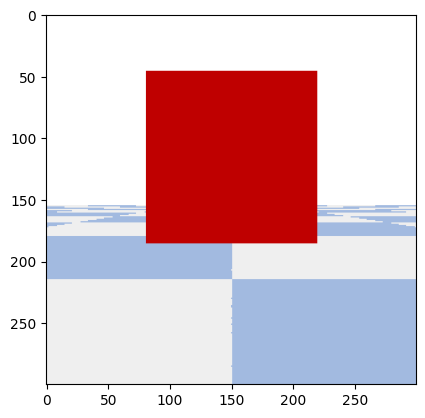

In [8]:
# jupyter book内にアニメーションを表示
def update(time, frames):
    plt.cla()
    frames_np = np.asarray(frames[time])
    plt.imshow(frames_np)

fig = plt.figure()
timeStepMilliSec = timeStep * 1000
ani = FuncAnimation(fig, update, interval=timeStepMilliSec*saveImgFreq, frames=len(frames), fargs=(frames,))
HTML(ani.to_jshtml()) # HTMLに
#ani.save('robot_camera.mp4', writer="ffmpeg") # mp4で保存．これを実行すると処理時間が増加します
# ani.save('robot_camera.gif', writer="imagemagick") # gifで保存．これを実行すると処理時間が増加します

## <a id='toc4_2_'></a>[超音波センサ](#toc0_)

超音波センサは、障害物との間との距離を計測するセンサです。

lidarと比較すると、計測距離は短いですが、安価に入手できることができます。


### <a id='toc4_2_1_'></a>[Lidarクラスの定義](#toc0_)
超音波センサではLidarクラスを流用します。(Lidarセンサの際に使用するクラスと全く同じです)

In [9]:
import math
import pybullet

class Lidar():
    def __init__(self):
        self.replaceItemUniqueIds = None

    # 姿勢を表す回転行列
    def rotation_matrix(self, roll, pitch, yaw):
        R_x = [[1, 0, 0],
                [0, math.cos(roll), -math.sin(roll)],
                [0, math.sin(roll), math.cos(roll)]]
        
        R_y = [[math.cos(pitch), 0, math.sin(pitch)],
                [0, 1, 0],
                [-math.sin(pitch), 0, math.cos(pitch)]]
        
        R_z = [[math.cos(yaw), -math.sin(yaw), 0],
                [math.sin(yaw), math.cos(yaw), 0],
                [0, 0, 1]]
        
        return np.dot(R_z, np.dot(R_y, R_x))

    def CheckHits(self, rayFromPosition, rayOrientation, rayLength, angleResolutionRad, rayDirectionRangeRad, offset, drawDebugLine=False):
        """
        姿勢を反映した障害物検知のためのレイキャスト
        Parameters
        ---
        rayFromPosition : list
            rayが始まる位置を格納したlist [x, y, z]
        orientation : list
            レイ発射元の姿勢 [roll, pitch, yaw]
        rayLength : float
            rayの長さ
        angleResolutionRad : float
            角度の分解能
        rayDirectionRangeRad : float
            rayを発射する範囲を格納したlist [startRad, endRad]
        offset : float
            rayFromPositionからのオフセット
        drawDebugLine : bool
            rayを描画するかどうか
        
        Returns
        ---
        hitResults: tuple
            レイキャストの結果
        """
        
        
        R = self.rotation_matrix(rayOrientation[0], rayOrientation[1], rayOrientation[2])
        
        # 分割数
        numDivisions = int((rayDirectionRangeRad[1] - rayDirectionRangeRad[0]) / angleResolutionRad)

        # rayDirectionRangeRadの範囲内で、numDivisions分だけrayの始点/終点を生成
        rayFroms = []
        rayToes = []
        for i in range(numDivisions):
            angle = rayDirectionRangeRad[0] + i * angleResolutionRad
            direction = [math.cos(angle), math.sin(angle), 0]
            
            # 回転行列を適用して方向ベクトルを回転
            rotatedDirection = np.dot(R, direction)

            # rayの始点
            rayFrom = rayFromPosition + offset * rotatedDirection
            rayFroms.append(rayFrom)

            # rayの終点
            rayTo = rayFrom + rayLength * rotatedDirection
            rayToes.append(rayTo)
        
        # numDivisions分のレイキャストを実施
        hitResults = pybullet.rayTestBatch(rayFroms, rayToes)

        # rayの描画
        if drawDebugLine:
            if self.replaceItemUniqueIds is None:
                self.replaceItemUniqueIds = []
                
                for i in range(numDivisions):
                    isHit = hitResults[i][0]
                    rayFrom = rayFroms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hitResults[i][3]
                        self.replaceItemUniqueIds.append(pybullet.addUserDebugLine(rayFrom, rayHitPosition, lineColorRGB=[1,0,0]))
                    else:
                        rayToPosition = rayToes[i]
                        self.replaceItemUniqueIds.append(pybullet.addUserDebugLine(rayFrom, rayToPosition, lineColorRGB=[0,1,0]))
            
            else:
                for i in range(numDivisions):
                    isHit = hitResults[i][0]
                    rayFrom = rayFroms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hitResults[i][3]
                        pybullet.addUserDebugLine(rayFrom, rayHitPosition, lineColorRGB=[1,0,0], replaceItemUniqueId=self.replaceItemUniqueIds[i])
                    else:
                        rayToPosition = rayToes[i]
                        pybullet.addUserDebugLine(rayFrom, rayToPosition, lineColorRGB=[0,1,0], replaceItemUniqueId=self.replaceItemUniqueIds[i])
        return hitResults

### <a id='toc4_2_2_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [10]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
timeStep = 1./240.
pybullet.setTimeStep(timeStep)

#床の読み込み
planeId = pybullet.loadURDF("plane.urdf")

# ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
# box1
mass = 5 # kg
box1Size = [0.3, 0.3, 0.3]
position2 = [1.5, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box1CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient)
box1VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient, rgbaColor=[0,1,0,1]) 
box1BodyId = pybullet.createMultiBody(mass, box1CollisionId, box1VisualId, position2, orientation2, physicsClientId=physicsClient)

# ロボットの読み込み
carStartPos = [0, 0, 0.1]  # 初期位置(x,y,z)を設定
carStartOrientation = pybullet.getQuaternionFromEuler([0,0,0])  # 初期姿勢(roll, pitch, yaw)を設定
carId = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",carStartPos, carStartOrientation)

# GUIモードの際のカメラの位置などを設定
cameraDistance = 1.2
cameraYaw = 0.1 # deg
cameraPitch = -90.5 # deg
cameraTargetPosition = [1.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, cameraTargetPosition)

### <a id='toc4_2_3_'></a>[シミュレーションの実行](#toc0_)

Lidarセンサでは全方向の障害物との距離を測定していましたが、一般でも入手可能な安価な超音波センサとして有名なHC-SR04では、+-15度程度が計測可能範囲になるので、それに合わせて範囲を設定しています。

シミュレーションを実行するとロボットが走行を開始し、ロボットの前方の近い距離に障害物が近づくと、センサで検知しロボットがその場で停止します。

In [11]:
# debug用の描画を初期化
pybullet.removeAllUserDebugItems()

# ロボットを初期位置にセット
carStartPos = [0, 0, 0.1]
carStartOrientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
carBodyIdx = 0
pybullet.resetBasePositionAndOrientation(carId, carStartPos, carStartOrientation)

# rayの設定
ultraSonicSensorLinkIdx = 6 # rayの発射位置のlinkのインデックス
rayDirectionStartDeg = -15
rayDirectionEndDeg = 15
rayDirectionRangeRad = [math.radians(rayDirectionStartDeg), math.radians(rayDirectionEndDeg)] # rayの範囲
angleResolutionDeg = 5 # 角度の分解能
angleResolutionRad = math.radians(angleResolutionDeg)
rayLength = 10 # rayの長さ
offset = 0.01

# 移動ロボットを前進させながらlidar情報を更新
ultraSonicSensor = Lidar()
for i in range(1000):
    # 2輪を前進するように速度制御
    pybullet.setJointMotorControl2(carId, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.setJointMotorControl2(carId, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)

    # 移動後のlidar情報を描画
    ultraSonicSensorPosition = pybullet.getLinkState(carId, ultraSonicSensorLinkIdx) # lidar linkの情報を取得
    rayFromPosition = [ultraSonicSensorPosition[0][0], ultraSonicSensorPosition[0][1], ultraSonicSensorPosition[0][2]] # # rayの始点をlidar linkの原点に設定
    ultraSonicSensorOrientation = list(pybullet.getEulerFromQuaternion(ultraSonicSensorPosition[1]))
    result = ultraSonicSensor.CheckHits(rayFromPosition, ultraSonicSensorOrientation, rayLength, angleResolutionRad, rayDirectionRangeRad, offset,  drawDebugLine=True) # lidar情報を取得
    
    # result内の距離が10cｍより小さい場合、停止
    for i in range(len(result)):
        if result[i][2] < 0.01:
            pybullet.setJointMotorControl2(carId, 0, pybullet.VELOCITY_CONTROL, targetVelocity=0)
            pybullet.setJointMotorControl2(carId, 1, pybullet.VELOCITY_CONTROL, targetVelocity=0)
            break
    pybullet.stepSimulation()
    time.sleep(timeStep)

# <a id='toc5_'></a>[バンパー](#toc0_)

バンパーセンサは、障害物と衝突したかどうかを検知するセンサです。


## <a id='toc5_1_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [12]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
timeStep = 1./240.
pybullet.setTimeStep(timeStep)

#床の読み込み
planeId = pybullet.loadURDF("plane.urdf")

# ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
# box1
mass = 5 # kg
box1Size = [0.3, 0.3, 0.3]
position2 = [0.8, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box1CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient)
box1VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient, rgbaColor=[1,0,0,1]) # 赤・半透明
box1BodyId = pybullet.createMultiBody(mass, box1CollisionId, box1VisualId, position2, orientation2, physicsClientId=physicsClient)


# ロボットの読み込み
carStartPos = [0, 0, 0.1]  # 初期位置(x,y,z)を設定
carStartOrientation = pybullet.getQuaternionFromEuler([0,0,0])  # 初期姿勢(roll, pitch, yaw)を設定
carId = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",carStartPos, carStartOrientation)

# GUIモードの際のカメラの位置などを設定
cameraDistance = 2.0
cameraYaw = 0.0 # deg
cameraPitch = -90.1 # deg
cameraTargetPosition = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, cameraTargetPosition)

## <a id='toc5_2_'></a>[シミュレーションの実行](#toc0_)
pybulletでは、`getJointState`関数を使用することで各ジョイントの情報を取得できます。  
この関数では、位置情報の他に力情報も取得できるため、バンパーセンサでは力情報を使用して障害物との衝突を検知します。

シミュレーションを開始すると、移動ロボットが走行を開始し、前方にある障害物にバンパが接触すると停止します。

- `enableJointForceTorqueSensor`の`enableSensor`を1に設定すると、バンパに障害物が接触した際にロボットが停止します。
- `enableJointForceTorqueSensor`の`enableSensor`を0に設定すると、バンパに障害物が接触しても反応せずに、前進し続けます。

In [15]:
# debug用の描画を初期化
pybullet.removeAllUserDebugItems()

forceSensorJointIdx = 4  # 力センサが取り付けられている関節のインデックス
pybullet.enableJointForceTorqueSensor(carId, forceSensorJointIdx, enableSensor=1) # 力センサの有効化 

# ロボットを初期位置にセット
carStartPos = [0, 0, 0.1]
carStartOrientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
carBodyIdx = 0
pybullet.resetBasePositionAndOrientation(carId, carStartPos, carStartOrientation)

for i in range(500):
    # bumperに加わる力を取得
    joint_state = pybullet.getJointState(carId, forceSensorJointIdx)
    forceX = joint_state[2][0]
    forceY = joint_state[2][1]
    forceZ = joint_state[2][2]

    # 画面上にbumperに加わっている力を表示
    textPosition = [0.0, 0.0, 0.5]
    lifeTime = 0.1 # 表示期間（秒）
    pybullet.addUserDebugText(f"force x:{forceX:.2f} y:{forceY:.2f} z:{forceZ:.2f}", textPosition, textSize=3, lifeTime=lifeTime, textColorRGB=[0,0,0])

    # bumperに対して、5以上の力が加わった場合、停止
    if forceX > 5:
        textPosition = [0.0, -0.1, 1.0]
        pybullet.addUserDebugText(f"bumber ON", textPosition, textSize=5, lifeTime=0.1, textColorRGB=[1,0,0])
        pybullet.setJointMotorControl2(carId, 0, pybullet.VELOCITY_CONTROL, targetVelocity=0)
        pybullet.setJointMotorControl2(carId, 1, pybullet.VELOCITY_CONTROL, targetVelocity=0)
    else:
        # 前進
        pybullet.setJointMotorControl2(carId, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
        pybullet.setJointMotorControl2(carId, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)

    # 次のステップへ
    pybullet.stepSimulation()
    time.sleep(timeStep)

b3Printf: b3Warning[examples/SharedMemory/PhysicsServerCommandProcessor.cpp,10339]:

b3Printf: CMD_CREATE_SENSOR: sensor for joint [4] already enabled


# <a id='toc6_'></a>[ボトムセンサー](#toc0_)
`bottom_sensor_link`は一つのlinkで

- ボトムカメラ
- 落下防止センサ

の2種類のセンサを模擬できます。

## <a id='toc6_1_'></a>[ボトムカメラ](#toc0_)
ボトムカメラでは地面の画像を取得できます。

フロントカメラと同様に、`getCameraImage`関数を使用して画像を取得します。

### <a id='toc6_1_1_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [3]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
timeStep = 1./240.
pybullet.setTimeStep(timeStep)

#床の読み込み
planeId = pybullet.loadURDF("plane.urdf")

# ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
# box1
mass = 5 # kg
box1Size = [0.3, 0.3, 0.3]
position2 = [2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box1CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient)
box1VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1Size, physicsClientId=physicsClient, rgbaColor=[1,0,0,1]) # 赤・半透明
box1BodyId = pybullet.createMultiBody(mass, box1CollisionId, box1VisualId, position2, orientation2, physicsClientId=physicsClient)

# box2
mass = 5 # kg
box2Size = [0.3, 1.0, 0.3]
position2 = [-2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # 四元数
box2CollisionId = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box2Size, physicsClientId=physicsClient)
box2VisualId = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box2Size, physicsClientId=physicsClient, rgbaColor=[1,0,0,1]) # 赤・半透明
box2BodyId = pybullet.createMultiBody(mass, box2CollisionId, box2VisualId, position2, orientation2, physicsClientId=physicsClient)

# ロボットの読み込み
carStartPos = [0, 0, 0.1]  # 初期位置(x,y,z)を設定
carStartOrientation = pybullet.getQuaternionFromEuler([0,0,0])  # 初期姿勢(roll, pitch, yaw)を設定
carId = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",carStartPos, carStartOrientation)

# GUIモードの際のカメラの位置などを設定
cameraDistance = 5.0
cameraYaw = 0.0 # deg
cameraPitch = -90.1 # deg
cameraTargetPosition = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, cameraTargetPosition)

### <a id='toc6_1_2_'></a>[シミュレーション実行](#toc0_)

シミュレーションを実行すると、ロボットの下に取り付けられたカメラから画像が取得されます。

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ロボットを初期位置にセット
carStartPos = [0, 0, 0.1]
carStartOrientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
carBodyIdx = 0
pybullet.resetBasePositionAndOrientation(carId, carStartPos, carStartOrientation)

# 時刻設定
timeLength = 200
saveImgFreq = 1 # 画像を保存する頻度（値が小さいほどより滑らかな動画になるが、処理時間が増加する）

# カメラ設定
projectionMatrix = pybullet.computeProjectionMatrixFOV(fov=45.0,aspect=1.0,nearVal=0.01,farVal=0.15)

# カメラ画像格納用配列
frames = []
    
# リンクのインデックス
cameraIdx = 8
cameraTargetIdx = 9

# ジョイントのインデックス
rightWheelJointIdx = 0
leftWheelJointIdx = 1

for t in range (timeLength):
    # 4輪のリンクを速度制御
    pybullet.setJointMotorControl2(carId, rightWheelJointIdx, pybullet.VELOCITY_CONTROL, targetVelocity=40)
    pybullet.setJointMotorControl2(carId, leftWheelJointIdx, pybullet.VELOCITY_CONTROL, targetVelocity=40)
    
    # 一時刻分、シミュレーションを進める
    pybullet.stepSimulation()

    # save_img_freqごとにカメラ画像を取得
    if t % saveImgFreq == 0:
        # カメラリンクの位置を取得
        cameraLinkPose = pybullet.getLinkState(carId, cameraIdx)[0]

        # 注視点用の仮想的なリンクの位置を取得
        cameraTargetLinkPose = pybullet.getLinkState(carId, cameraTargetIdx)[0] 
        
        # カメラリンク -> 注視点用の仮想的なリンク 方向のviewMatrixを取得
        viewMatrix = pybullet.computeViewMatrix(
            cameraEyePosition=[cameraLinkPose[0], cameraLinkPose[1], cameraLinkPose[2]],
            cameraTargetPosition=[cameraTargetLinkPose[0], cameraTargetLinkPose[1], cameraTargetLinkPose[2]],
            cameraUpVector=[1, 0, 0])
        

        # カメラ情報を設定
        # renderer=pybullet.ER_BULLET_HARDWARE_OPENGLを指定することで、画質は下がる分高速に画像を取得できる
        width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(300,300, viewMatrix, projectionMatrix, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
        
        # 取得したカメラ画像をリストに格納
        frames.append(rgbImg)
        


### <a id='toc6_1_3_'></a>[取得した画像のアニメーション化](#toc0_)

取得した画像をアニメーション化して表示します。  

(GUI画面で表示したときと比較して、アニメーションの速度が速いと思いますが、これは`getCameraImage`関数の処理が遅いためであり、本来の速度は下記コードで生成されるアニメーションの速度になります。)

In [ ]:
# jupyter book内にアニメーションを表示
def update(time, frames):
    plt.cla()
    frames_np = np.asarray(frames[time])
    plt.imshow(frames_np)

fig = plt.figure()
timeStepMilliSec = timeStep * 1000
ani = FuncAnimation(fig, update, interval=timeStepMilliSec*saveImgFreq, frames=len(frames), fargs=(frames,))
HTML(ani.to_jshtml()) # HTMLに
#ani.save('robot_camera.mp4', writer="ffmpeg") # mp4で保存．これを実行すると処理時間が増加します
# ani.save('robot_camera.gif', writer="imagemagick") # gifで保存．これを実行すると処理時間が増加します

## <a id='toc6_2_'></a>[落下防止センサ](#toc0_)

落下防止センサでは、ロボットの前方下側に床があるかどうかを判別できます。

### <a id='toc6_2_1_'></a>[Lidarクラスの定義](#toc0_)

落下防止センサでは、Lidarクラスを流用します（Lidarセンサの際に使用するクラスと全く同じです）。

In [16]:
import math
import pybullet

class Lidar():
    def __init__(self):
        self.replaceItemUniqueIds = None

    # 姿勢を表す回転行列
    def rotation_matrix(self, roll, pitch, yaw):
        R_x = [[1, 0, 0],
                [0, math.cos(roll), -math.sin(roll)],
                [0, math.sin(roll), math.cos(roll)]]
        
        R_y = [[math.cos(pitch), 0, math.sin(pitch)],
                [0, 1, 0],
                [-math.sin(pitch), 0, math.cos(pitch)]]
        
        R_z = [[math.cos(yaw), -math.sin(yaw), 0],
                [math.sin(yaw), math.cos(yaw), 0],
                [0, 0, 1]]
        
        return np.dot(R_z, np.dot(R_y, R_x))

    def CheckHits(self, rayFromPosition, rayOrientation, rayLength, angleResolutionRad, rayDirectionRangeRad, offset, drawDebugLine=False):
        """
        姿勢を反映した障害物検知のためのレイキャスト
        Parameters
        ---
        rayFromPosition : list
            rayが始まる位置を格納したlist [x, y, z]
        orientation : list
            レイ発射元の姿勢 [roll, pitch, yaw]
        rayLength : float
            rayの長さ
        angleResolutionRad : float
            角度の分解能
        rayDirectionRangeRad : float
            rayを発射する範囲を格納したlist [startRad, endRad]
        offset : float
            rayFromPositionからのオフセット
        drawDebugLine : bool
            rayを描画するかどうか
        
        Returns
        ---
        hitResults: tuple
            レイキャストの結果
        """
        
        
        R = self.rotation_matrix(rayOrientation[0], rayOrientation[1], rayOrientation[2])
        
        # 分割数
        numDivisions = int((rayDirectionRangeRad[1] - rayDirectionRangeRad[0]) / angleResolutionRad)

        # rayDirectionRangeRadの範囲内で、numDivisions分だけrayの始点/終点を生成
        rayFroms = []
        rayToes = []
        for i in range(numDivisions):
            angle = rayDirectionRangeRad[0] + i * angleResolutionRad
            direction = [math.cos(angle), math.sin(angle), 0]
            
            # 回転行列を適用して方向ベクトルを回転
            rotatedDirection = np.dot(R, direction)

            # rayの始点
            rayFrom = rayFromPosition + offset * rotatedDirection
            rayFroms.append(rayFrom)

            # rayの終点
            rayTo = rayFrom + rayLength * rotatedDirection
            rayToes.append(rayTo)
        
        # numDivisions分のレイキャストを実施
        hitResults = pybullet.rayTestBatch(rayFroms, rayToes)

        # rayの描画
        if drawDebugLine:
            if self.replaceItemUniqueIds is None:
                self.replaceItemUniqueIds = []
                
                for i in range(numDivisions):
                    isHit = hitResults[i][0]
                    rayFrom = rayFroms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hitResults[i][3]
                        self.replaceItemUniqueIds.append(pybullet.addUserDebugLine(rayFrom, rayHitPosition, lineColorRGB=[1,0,0]))
                    else:
                        rayToPosition = rayToes[i]
                        self.replaceItemUniqueIds.append(pybullet.addUserDebugLine(rayFrom, rayToPosition, lineColorRGB=[0,1,0]))
            
            else:
                for i in range(numDivisions):
                    isHit = hitResults[i][0]
                    rayFrom = rayFroms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hitResults[i][3]
                        pybullet.addUserDebugLine(rayFrom, rayHitPosition, lineColorRGB=[1,0,0], replaceItemUniqueId=self.replaceItemUniqueIds[i])
                    else:
                        rayToPosition = rayToes[i]
                        pybullet.addUserDebugLine(rayFrom, rayToPosition, lineColorRGB=[0,1,0], replaceItemUniqueId=self.replaceItemUniqueIds[i])
        return hitResults


### <a id='toc6_2_2_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [30]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定

#床の読み込み
planeId = pybullet.loadURDF("plane.urdf")


# ロボットの読み込み
carStartPos = [0, 0, 1.0]
carStartOrientation = pybullet.getQuaternionFromEuler([0,0,0])  # 初期姿勢(roll, pitch, yaw)を設定
# urdfファイルのmeshはテクスチャが反映されないっぽいので各linkにrgbaタグで色を付けている
carId = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",carStartPos, carStartOrientation)


# # ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
mass = 5 # kg
position = [-4.5, -4.5, 0.3]
orientation = [1, 0, 0, 0] # 四元数
# 地面に固定した状態でボックスを配置
boxId = pybullet.loadURDF("/home/ubuntu/practice_pybullet/pybullet_code/urdf/plane_box.urdf", position, orientation, useFixedBase=True)


# GUIモードの際のカメラの位置などを設定
# 正面から見る設定
cameraDistance = 1.0
cameraYaw = -70.1 # deg
cameraPitch = 210.1 # deg
cameraTargetPosition = [0.0, 0.0, 0.5]
pybullet.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, cameraTargetPosition)

### <a id='toc6_2_3_'></a>[シミュレーションの実行](#toc0_)
Lidarや超音波センサでは、水平方向にrayを飛ばしていましたが、落下防止センサでは垂直方向にrayを飛ばすことで、床があるかどうかを判別します。

シミュレーションを実行すると、段差がある床にロボットが生成され走行を開始します。  
そして、ロボットが床から飛び出そうになった際は、落下防止センサが検知し、ロボットがその場で停止します。

In [33]:
# debug用の描画を初期化
pybullet.removeAllUserDebugItems()
timeStep = 1./240.
pybullet.setTimeStep(timeStep)

# ロボットを初期位置にセット
carStartPos = [0, 0, 1.0]
carStartOrientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
carBodyIdx = 0
pybullet.resetBasePositionAndOrientation(carId, carStartPos, carStartOrientation)


# rayの設定
lidarLinkIdx = 8 # ロボット下部センサの発射位置のlinkのインデックス
rayDirectionStartDeg = -90
rayDirectionEndDeg = 90
rayDirectionRangeRad = [math.radians(rayDirectionStartDeg), math.radians(rayDirectionEndDeg)] # rayの範囲
angleResolutionDeg = 5 # 角度の分解能
angleResolutionRad = math.radians(angleResolutionDeg)
rayLength = 0.1 # rayの長さ
offset = 0.05

lidar = Lidar()
for i in range(500):
    # 2輪を前進するように速度制御
    pybullet.setJointMotorControl2(carId, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.setJointMotorControl2(carId, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)



    # 移動後のlidar情報を描画
    lidarPosition = pybullet.getLinkState(carId, lidarLinkIdx) # lidar linkの情報を取得
    rayFromPosition = [lidarPosition[0][0], lidarPosition[0][1], lidarPosition[0][2]] # # rayの始点をlidar linkの原点に設定
    # ロボットの姿勢を取得
    orientation = list(pybullet.getEulerFromQuaternion(lidarPosition[1]))
    orientation[1] += math.radians(90)
    rayResults = lidar.CheckHits(rayFromPosition, orientation, rayLength, angleResolutionRad, rayDirectionRangeRad, offset, drawDebugLine=True) # lidar情報を取得

    # rayが障害物と衝突しているかどうかを確認
    isHit = False
    for rayResult in rayResults:
        if rayResult[0] != -1:
            isHit = True
            break
    
    # 障害物と衝突していない場合、進行先に床がないと判断しロボットを停止
    if isHit is False:
        # ロボットを停止
        pybullet.setJointMotorControl2(carId, 0, pybullet.VELOCITY_CONTROL, targetVelocity=0)
        pybullet.setJointMotorControl2(carId, 1, pybullet.VELOCITY_CONTROL, targetVelocity=0)
        break

    pybullet.stepSimulation()
    

    time.sleep(timeStep)